# 0. SETUP

## 0.1. Módulos comuns

In [1]:
from numpy import *
from numpy.linalg import *
from matplotlib.pyplot import *
from matplotlib.collections import PatchCollection
from scipy.optimize import minimize
import time

## 0.2. Módulos do projeto

In [2]:
from project_modules import graphics    # For plots
from project_modules import graph_utils # Graph manipulation
from project_modules import model_math  # The mathematical functions of the model

## 0.3. Parâmetros do problema

In [3]:
SCALE = 1.0        # How much each screen element is going to be scaled. Default is 1.0
SCREEN_HEIGHT = 30 # The height of the screen that contains the overlapping windows in pixels
SCREEN_WIDTH = 30  # The width of the screen that contains the overlapping windows in pixels
MAX_WINDOW_DIM = 3 # The max height or width each window can have. For the project the default is 3.
MIN_WINDOW_DIM = 2 # The minimum height or width each window can have. For the project the default is 2.
CLUSTER_DISTANCE_FROM_SCREEN_CENTER = 6 # The distance from the clusters to the screen center in pixels
POINT_DISTANCE_FROM_CLUSTER = 2         # How far the points can be from the cluster in pixels
KNN_K = 2         # The number of closest neighbors considered for building the connectivity graph
ALPHA = 0.2       # The weighting value for the energy function between E_N and E_O
SEED = 1        # Seed used for random numbers generation

## 0.4. Preprocessamento dos parâmetros

In [4]:
# Rescale
SCREEN_HEIGHT *= SCALE
SCREEN_WIDTH *= SCALE
MAX_WINDOW_DIM *= SCALE
MIN_WINDOW_DIM *= SCALE
CLUSTER_DISTANCE_FROM_SCREEN_CENTER *= SCALE
POINT_DISTANCE_FROM_CLUSTER *= SCALE
# Compute screen center
SCREEN_CENTER = array([ floor(SCREEN_WIDTH/2), floor(SCREEN_HEIGHT/2) ])
# Set a seed for reproducibility purposes
random.seed(SEED)

# 1. PREPARAÇÃO DOS DADOS

Os vetores $P_j$ gerados possuem dimensão $4$: a posição $x$ e $y$ (coluna) da origem do retângulo (ponto superior esquerdo), a altura do retângulo $h$ e a largura $w$, e o cluster $c_j$ ao qual ele pertence, de forma que $P_j=(x_j,y_j,h_j,w_j, c_j)$.

## 1.1 Gerar Centros

In [5]:
n_groups = random.randint(3,7)
angle_between_points = (2.0 * pi / n_groups * arange(0 , n_groups)) # The array of the angle of each cluster w.r.t. the x-axis
clusters = transpose( # Each row is a pair x,y from each cluster
    array( [
        CLUSTER_DISTANCE_FROM_SCREEN_CENTER * cos( angle_between_points ) + SCREEN_CENTER[0],
        CLUSTER_DISTANCE_FROM_SCREEN_CENTER * sin( angle_between_points ) + SCREEN_CENTER[1]
    ] )
)

## 1.2 Gerar pontos ao redor dos centros

In [6]:
size_groups = random.randint(5, 16, n_groups)
points = zeros((sum(size_groups),5)) # [x, y, w, h, label]
j = 0
for cluster_idx in range(n_groups):
    for idx in range(size_groups[cluster_idx]):
        # Point position
        points[j,:2] = clusters[cluster_idx] + random.randint(-POINT_DISTANCE_FROM_CLUSTER,POINT_DISTANCE_FROM_CLUSTER, 2)
        # Point dimension
        points[j,2:4] = random.randint(MIN_WINDOW_DIM,MAX_WINDOW_DIM+1,2)
        # cluster_information
        points[j,4] = cluster_idx
        j += 1
        
points_pos = points[:,:2] # position vectors
points_dims = points[:,2:4] # dimension vectors

## 1.3 Cálculo da Laplaciana e dos deltas

In [7]:
_LAPLACIAN_L = graph_utils.laplacian_graph(points_pos, K=KNN_K)
_DELTA_X = _LAPLACIAN_L.dot(points_pos[:,0])
_DELTA_Y = _LAPLACIAN_L.dot(points_pos[:,1])

## 1.4 Mostrar os dados

### Disposição inicial das janelas

<Figure size 432x288 with 0 Axes>

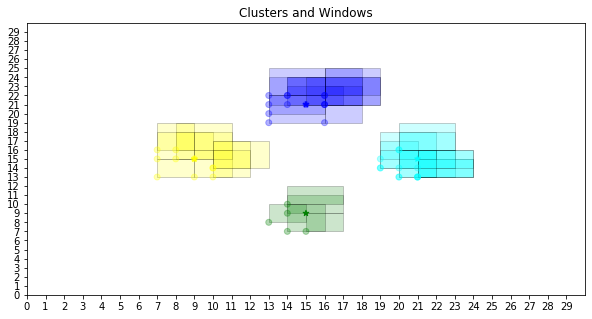

In [8]:
graphics.draw_windows(clusters, points_pos, points_dims, points[:,4], n_groups, size_groups, SCREEN_HEIGHT, SCREEN_WIDTH, SCALE)

### Grafo de conectividade

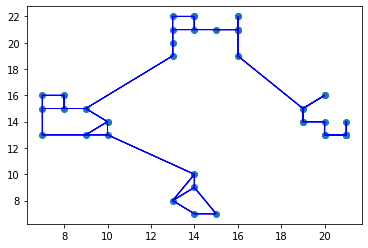

In [9]:
G = graph_utils.adjacency_matrix(points_pos, KNN_K)
graph_utils.connectivity_scatter(points_pos, G)

### Laplaciana

<Figure size 432x288 with 0 Axes>

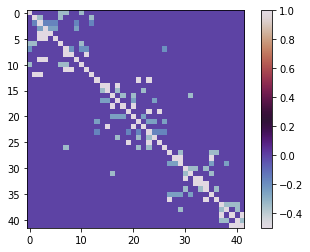

In [10]:
clf()
rcParams["image.cmap"] = 'twilight'
fig, ax = subplots()
aa = ax.imshow(_LAPLACIAN_L)
cbar = fig.colorbar(aa)

# 2. Modelagem Matemática


O problema se resume a minimizar $E(X) = (1-\alpha) E_O(X) + \alpha E_N(X) $, em que $X=(x_j, y_j)$ e $\alpha \in [0,1]$. $E_0$ e $E_N$ são as funções de energia de overlap e a de relação entre os vizinhos. Mais detalhes sobre as funções podem ser encontradas [neste link](https://ieeexplore.ieee.org/abstract/document/6629989).

In [11]:
def E_N(X):
    w = X[-1]
    X = reshape(X[:-1], (points.shape[0], 2)) # Removes w from the state
    e_n = model_math.E_N(X, w, _LAPLACIAN_L, _DELTA_X, _DELTA_Y)
    return e_n

def E_O(X):
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    e_o = model_math.E_O(X, points_dims)
    return e_o

# 3. Solução Numérica

## 3.1 Função

In [12]:
alpha = ALPHA

def f (X):
    e_n = E_N(X)
    e_o = E_O(X)
    return alpha * e_n + (1.0- alpha) * e_o

def jac_f(X):
    w = X[-1]
    X = reshape(X[:-1], (points.shape[0], 2))
    jac_E_O = model_math.jac_E_O(X, points_dims)
    jac_E_N = model_math.jac_E_N(X[:,0], X[:,1], w, _LAPLACIAN_L, _DELTA_X, _DELTA_Y)
    jac_E = alpha * jac_E_N + (1.0-alpha) * jac_E_O
    return jac_E

## 3.2 Restrições

A implementação das restrições foi adapatada para as condições do SciPy nas quais as desigualdades são do tipo $r_i(X) \geq 0$ [(fonte)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize).

In [13]:
x_min = 0; x_max = SCREEN_WIDTH
y_min = 0; y_max = SCREEN_HEIGHT

# r1: x_min-x_i <= 0 <=> x_i - x_min >= 0
def constr_fun_1(X):
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    return model_math.constr_fun_1(X, x_min)

# r2: x_i - x_max + h_i <= 0 <=> x_max - x_i - h_i >= 0
def constr_fun_2(X):
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    return model_math.constr_fun_2(X, x_max, points_dims)

# r3: y_min-y_i <= 0 <=> y_i - y_min >= 0
def constr_fun_3(X):
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    return model_math.constr_fun_3(X, y_min)

# r4: y_i - y_max + v_i <= 0 <=> y_max - y_i - v_i >= 0
def constr_fun_4(X):
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    return model_math.constr_fun_4(X,y_max, points_dims)

constrs = (
    {'type': 'ineq', 'fun':  constr_fun_1},
    {'type': 'ineq', 'fun':  constr_fun_2},
    {'type': 'ineq', 'fun':  constr_fun_3},
    {'type': 'ineq', 'fun':  constr_fun_4},
)

## 3.3 Minimização

### Armazenar as energias a cada iteração

In [14]:
list_energy_overlapping = []
list_energy_neighborhood = []
list_energy = []

# Stores the energy computed for each iteration
def iter_callback(xk):
    list_energy_overlapping.append(E_O(xk))
    list_energy_neighborhood.append(E_N(xk))
    list_energy.append(f(xk))
    return

### Inicia o processo de minização

In [ ]:
w_init = 1.0
X_init = append(points_pos.flatten(), [w_init])

# Minimizer 
use_grad = True
use_cons = True
res = None

method = 'SLSQP'
maxiter = 1e4
cons = None
if(use_cons):
    cons = constrs
start_time = time.time()
if(use_grad):
    res = minimize(
        f, X_init, 
        method=method, 
        jac=jac_f,
        #hess=hess_f,
        constraints=cons, 
        tol=1e-10, 
        options={"maxiter" : maxiter},
        callback=iter_callback
    )
else:
    res = minimize(
        f, X_init, 
        method=method, 
        constraints=cons, 
        tol=1e-9, 
        options={"maxiter" : maxiter},
        callback=iter_callback
    )
delta_T_sec = time.time() - start_time
print("=============================================")
print("Finished! Took {} seconds (or {} minutes)!".format(delta_T_sec, delta_T_sec/60.0 ))
print("The objective function of the result is: {}".format(res["fun"]))
print("=============================================")

# 4. Visualização dos Resultados

## Disposição final das janelas

In [ ]:
X_final = reshape(res["x"][:-1], (points.shape[0], 2))
graphics.draw_windows(clusters, X_final, points_dims, points[:,4], n_groups, size_groups, SCREEN_HEIGHT, SCREEN_WIDTH, SCALE)

## Comportamento das funções de energia

In [ ]:
clf()
plot(list_energy_overlapping, label=r"$E_O$")
plot(list_energy_neighborhood, label=r"$E_N$")
plot(list_energy, label=r"$E$")
legend()
show()